In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set_theme(style='white', palette='crest', font_scale=0.8, rc={'figure.figsize': (8, 6)})
pd.set_option("display.float_format", lambda x: "{:.4f}".format(x))

In [3]:
# RISK & RETURN METRICS

def performance_summary(return_data, adj_factor=12):
    summary = {"Mean": return_data.mean() * adj_factor,
               "Volatility": return_data.std() * np.sqrt(adj_factor)}
    summary["Sharpe Ratio"] = (
            summary["Mean"] / summary["Volatility"]
    )
    return pd.DataFrame(summary, index=return_data.columns)

def calc_return_metrics(data, adj):
    summary = dict()
    summary["Annualized Mean"] = data.mean() * adj
    summary["Annualized Volatility"] = data.std() * np.sqrt(adj)
    summary["Annualized Sharpe Ratio"] = (
            summary["Annualized Mean"] / summary["Annualized Volatility"]
    )
    return pd.DataFrame(summary, index=data.columns)

def calc_risk_metrics(data, qt):
    summary = dict()
    summary[f"VaR ({qt})"] = data.quantile(qt, axis=0)
    wealth_index = 1000 * (1 + data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    summary["MDD"] = drawdowns.min()
    return pd.DataFrame(summary, index=data.columns)

In [4]:
# LINEAR FACTOR DECOMPOSITION

def get_ols_metrics(regressors, targets, annualization=12, ignorenan=True):
    if not isinstance(regressors, pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets, pd.DataFrame):
        targets = targets.to_frame()

    df_aligned = targets.join(regressors, how='inner', lsuffix='y ')
    Y = df_aligned[targets.columns]
    Xset = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        _y = Y[col]

        if ignorenan:
            alldata = Xset.join(_y, lsuffix='X')
            mask = alldata.notnull().all(axis=1)
            _y = _y[mask]
            _X = Xset[mask]
        else:
            _X = Xset

        _model = LinearRegression().fit(_X, _y)
        reg.loc[col, 'Alpha'] = _model.intercept_ * annualization

        reg.loc[col, regressors.columns] = _model.coef_
        reg.loc[col, 'R-squared'] = _model.score(_X, _y)


        y_fit = _model.predict(_X)
        residuals = _y - y_fit

        if Xset.shape[1] == 1:
            reg.loc[col, 'Treynor Ratio'] = (_y.mean() / _model.coef_) * annualization

        num_roundoff = 1e-12
        if np.abs(_model.intercept_) < num_roundoff:
            reg.loc[col, 'Info Ratio'] = None
        else:
            reg.loc[col, 'Info Ratio'] = (_model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg

In [5]:
# PORTFOLIO OPTIMIZATION

def tangency_portfolio(return_data, cov):
    inv_cov = np.linalg.inv(cov)
    ones = np.ones(return_data.shape)
    weights = inv_cov @ return_data / (ones.T @ inv_cov @ return_data)
    try:
        return pd.DataFrame(weights, index=return_data.index)
    except AttributeError:
        return weights

def gmv_portfolio(cov):
    try:
        cov_inv = np.linalg.inv(cov)
    except TypeError:
        cov_inv = np.linalg.inv(np.array(cov))

    ones = np.ones(len(cov.index))
    weights = cov_inv @ ones / (ones @ cov_inv @ ones)
    try:
        return pd.DataFrame(weights, index=cov.index)
    except AttributeError:
        return weights

def mv_portfolio(return_data, cov, target=None):
    w_tan = tangency_portfolio(return_data, cov)
    if target is None:
        return w_tan

    w_gmv = gmv_portfolio(cov)
    delta = (target - return_data @ w_gmv) / (return_data @ w_tan - return_data @ w_gmv)
    scaled_weights = delta * w_tan + (1 - delta) * w_gmv
    try:
        return pd.DataFrame(scaled_weights, index=return_data.index)
    except AttributeError:
        return scaled_weights

# 1. Return Analysis

In [6]:
rets = pd.read_excel(
    "midterm_A_2023_data.xlsx",
    sheet_name="commodities (excess returns)",
    index_col=0,
    parse_dates=True,
)
rets.head()

,NG1,KC1,CC1,LB1,CT1,SB1,LC1,W1,S1,C1,GC1,SI1,HG1,PA1
Date,,,,,,,,,,,,,,
2000-01-31,0.1389,-0.1217,-0.0543,-0.0110,0.1362,-0.1185,0.0204,0.0271,0.0961,0.0717,-0.0262,-0.0274,-0.0141,0.0749
2000-02-29,0.0329,-0.1051,-0.0571,-0.0516,-0.0261,-0.1464,-0.0100,-0.0404,-0.0176,-0.0270,0.0345,-0.0495,-0.0718,0.4646
2000-03-31,0.0619,0.0333,0.0577,-0.0214,0.0225,0.2641,0.0300,0.0570,0.0836,0.0930,-0.0584,-0.0102,0.0118,-0.1683
2000-04-30,0.0620,-0.0856,-0.0709,-0.0822,-0.0464,-0.1300,0.0242,-0.0809,-0.0394,-0.0565,-0.0179,-0.0166,-0.0171,0.0375
2000-05-31,0.3818,-0.0291,0.1222,-0.0133,0.1194,0.4582,-0.0923,0.1292,-0.0221,0.0006,-0.0159,-0.0088,0.0216,-0.0674



### 1. Annualized excess return statistics
• mean
• volatility
• Sharpe ratio

In [7]:
metrics = calc_return_metrics(rets, adj=12)
display(metrics)

,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio
NG1,0.1440,0.5381,0.2676
KC1,0.0450,0.3209,0.1401
CC1,0.0848,0.3246,0.2612
LB1,0.1309,0.4008,0.3267
CT1,0.0572,0.3071,0.1864
SB1,0.0913,0.3467,0.2635
LC1,0.0296,0.1876,0.1576
W1,0.0761,0.3116,0.2441
S1,0.0713,0.2651,0.2688
C1,0.0861,0.2986,0.2882


### 2. Risk metrics
- VaR (0.01)
- CVaR (0.01)
- Max Drawdown

In [8]:
display(calc_risk_metrics(rets, qt=0.01))

,VaR (0.01),MDD
NG1,-0.3590,-0.9015
KC1,-0.1781,-0.7044
CC1,-0.1981,-0.5115
LB1,-0.2393,-0.7117
CT1,-0.2069,-0.7640
SB1,-0.2015,-0.7109
LC1,-0.1272,-0.4947
W1,-0.1922,-0.6695
S1,-0.2141,-0.5484
C1,-0.1961,-0.6339


### 3.

If I can only invest in a single asset, the statistics I would recommend that an investor is the **Sharpe ratio**. The Sharpe ratio is the ratio of the mean return to the volatility and is a measure of risk-adjusted return, and the higher, the better.

Meanwhile, I will take a look at other return statistics for reference.

In [9]:
display(metrics["Annualized Sharpe Ratio"].nlargest(3))

GC1   0.5017
PA1   0.3678
HG1   0.3614
Name: Annualized Sharpe Ratio, dtype: float64

In [10]:
top3_mean = pd.Series(metrics["Annualized Mean"].nlargest(3).index)
bottom3_vol = pd.Series(metrics["Annualized Volatility"].nsmallest(3).index)
top3_sharpe = pd.Series(metrics["Annualized Sharpe Ratio"].nlargest(3).index)
worst3_sharpe = pd.Series(metrics["Annualized Sharpe Ratio"].nsmallest(3).index)
pd.DataFrame([top3_mean, bottom3_vol, top3_sharpe, worst3_sharpe],
             index=["Best Mean", "Best Vol", "Best SR", "Worst SR"]).T

,Best Mean,Best Vol,Best SR,Worst SR
0,NG1,GC1,GC1,KC1
1,LB1,LC1,PA1,LC1
2,PA1,HG1,HG1,CT1


I will recommend the investor to consider `GC1` because it has the lowest volatility and highest Sharpe ratio, meaning that means it provides a relatively high return for each unit of risk taken. Even though `NG1` has the highest mean return, it also has the highest volatility, meaning that it has a high per unit return. Unless the investor focuses only on maximizing return and is an absolute risk-taker, which is very unlikely, I will not recommend `NG1`.

### 4.

My answer will be different. Since I am adding an asset to an existing large portfolio, individual statistics do not suffice—it is an asset's correlation or covariance with the existing portofolio I need to care about the most.  I would want to choose an asset that has a low correlation with the other assets in my portfolio as it leads to better diversification and can reduce portfolio risk.

Also, I will look at the characters of an investor's existing portfolio—if it is heavily invested in volatile or high-risk assets, I will recommend the one with the lowest risk because of its lower volatility and risk of extreme losses.

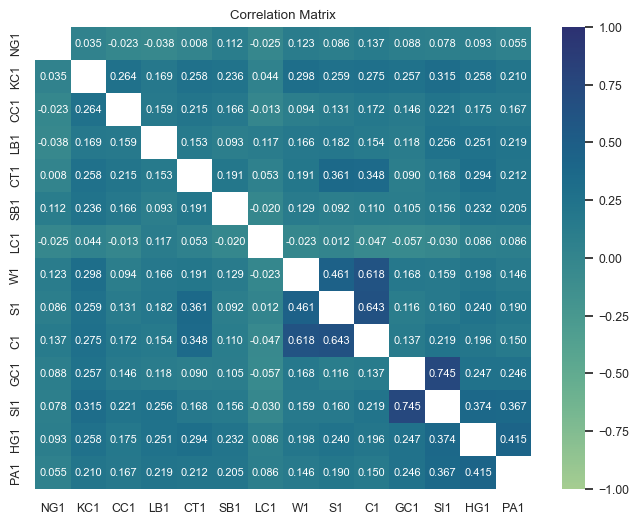

In [11]:
corr_matrix = rets.corr()
np.fill_diagonal(corr_matrix.values, np.nan)
sns.heatmap(corr_matrix, annot=True, cmap="crest", vmin=-1, vmax=1, annot_kws={"size": 8}, fmt=".3f").set_title("Correlation Matrix")
plt.show()

I will recommend `LC1` based on the principles above, or maybe `GC1`, whose correlation measures are not as low as LC1, but it has higher reward.

1. `LC1` is the asset with the lowest correlation with all other assets by sum of absolute correlation.
2. `LC1` and `GC1` has the lowest raw correlation (-0.06). However, as mentioned in the previous question, I will not recommend `GC1` as it has a high volatility. I cannot expect an average investor to be an absolute risk-taker.2. I would have a low correlation with the other assets in my portfolio. This is because I want to diversify my portfolio and reduce the risk of my portfolio. I would choose LC1.

CT1 also doesn't seem like a bad choice as it has a low correlation with all other assets except for `SB1` and `C1`. However, I will still choose `LC1` as it has a lower correlation with `SB1` and `C1` than `CT1`..

In [12]:
display(corr_matrix.unstack().sort_values(key=abs, ascending=True).dropna().drop_duplicates().head(2))
display(corr_matrix.unstack().sort_values(ascending=True).dropna().drop_duplicates().head(2))

CT1  NG1   0.0081
LC1  S1    0.0123
dtype: float64

GC1  LC1   -0.0572
LC1  C1    -0.0473
dtype: float64

In [13]:
# find the asset with the lowest correlation with all other assets
print(f"Asset with the lowest sum of absolute correlation with others:\n{corr_matrix.abs().sum().idxmin()}")
print(f"Asset with the lowest sum of correlation with others:\n{corr_matrix.sum().idxmin()}")

Asset with the lowest sum of absolute correlation with others:
LC1
Asset with the lowest sum of correlation with others:
LC1


### 5. Linear Factor Decomposition


In [14]:
pricing_reg = get_ols_metrics(rets.SB1, rets.C1, annualization=12)
display(pricing_reg.style.format('{:,.2%}'))

,Alpha,SB1,R-squared,Treynor Ratio,Info Ratio
C1,7.74%,9.44%,1.20%,91.11%,26.09%


- The market alpha is 0.0074.
- The market beta is the coefficient of C1 which is 0.0944.
- The market information ratio is 0.2609.

### 6.

In [15]:
pricing_reg.loc['C1', 'SB1']

0.09444854394093133

The regression coefficient between C1 and SB1 gives the hedge ratio between the two, which is 9.44%. This means that for every 1% increase in coffee, sugar will increase by 9.44%.

In a simple linear regression of sugar on coffee, the slope coefficient (beta) would be the same as the hedge ratio.

# 2 Mean Variance Optimization

### 1. tangency portfolio

In [16]:
weight_tan = tangency_portfolio(rets.mean(), rets.cov())
display(weight_tan.sort_values(by=0, ascending=False))

,0
GC1,0.6031
LC1,0.1289
LB1,0.0866
C1,0.0848
HG1,0.0746
CC1,0.0745
PA1,0.0733
SB1,0.0636
NG1,0.0574
S1,0.0273


In [17]:
performance_summary(rets @ weight_tan, adj_factor=12)

,Mean,Volatility,Sharpe Ratio
0,0.0875,0.1163,0.7524


### 2. mean-variance portfolios with target return

If a risk-free rate is not available, we invest all into the risky assets, and the weights have to sum to 1.

In [18]:
w_target = mv_portfolio(rets.mean(), rets.cov(), 0.0075)
display(w_target.sort_values(by=0, ascending=False))
print(f"sum of weights in risky assets: {w_target.sum().values[0]:.4f}")

,0
GC1,0.6085
LC1,0.1100
LB1,0.0940
C1,0.0897
PA1,0.0812
HG1,0.0774
CC1,0.0764
SB1,0.0654
NG1,0.0616
S1,0.0245


sum of weights in risky assets: 1.0000


When a risk-free rate is available, the weights of the risky assets need not add up to 1. The result of the MV portfolio is a combination of the tangency portfolio and a position in the riskless asset.

In [19]:
def mv_portfolio_riskfree(return_data, cov, target_return):
    inv_cov = np.linalg.inv(cov)
    ones = np.ones(return_data.shape)
    weights = inv_cov @ return_data / (ones.T @ inv_cov @ return_data)
    weights = weights * target_return / (weights.T @ return_data)
    try:
        return pd.DataFrame(weights, index=return_data.index)
    except AttributeError:
        return weights


w_target_riskfree = mv_portfolio_riskfree(rets.mean(), rets.cov(), 0.0075)
display(w_target_riskfree.sort_values(by=0, ascending=False))
print(f"sum of weights in risky assets: {w_target_riskfree.sum().values[0]:.5f}")

,0
GC1,0.6202
LC1,0.1326
LB1,0.0891
C1,0.0872
HG1,0.0767
CC1,0.0766
PA1,0.0754
SB1,0.0654
NG1,0.0591
S1,0.0281


sum of weights in risky assets: 1.02842


### 3

The tangency portfolio does not weigh securities in order of their individual Sharpe ratios but considers the entire portfolio's reward versus risk, or return versus volatility. The tangency portfolio also encapsulates the correlation between assets in a portfolio and is the portfolio on the risky MV frontier with the maximum Sharpe ratio.

### 4

In [20]:
performance_summary(rets @ w_target, adj_factor=12)

,Mean,Volatility,Sharpe Ratio
0,0.0900,0.1198,0.7516


In [21]:
performance_summary(rets @ w_target_riskfree, adj_factor=12)

,Mean,Volatility,Sharpe Ratio
0,0.0900,0.1196,0.7524


### 5 HCM

- Needless to say, HCM used diversification and identified correlations: i.e., HCM invested in a diverse array of asset classes such as real estate, private equity. That diversification reduces risk and enhances returns is well understood, but it HCM's innovations below made them above and beyond.

- HCM used a two-stage optimization. Rather than trying to optimize across all individual securities simultaneously (could be thousands), they first optimized portfolios within each asset class. Then, they combined these in a second-stage optimization. This made the problem more tractable.

- HMC focused on real returns, those adjusted for inflation, rather than nominal returns when analyzing its portfolio allocation. This gives a more accurate reflection of the actual purchasing power in the future and makes the portfolio allocation more realistic.

- HCM imposed constraints on allocations to different asset classes, which reflect considerations regarding investment limitations and risk management in the real world, such as short-selling or the maximum budget on a particular asset class.


### 6

The mean-variance optimization is a quadratic programming problem with a non-convex objective function.
- It is not robust as it heavily relies on the estimated returns, variances, and covariances of asset returns. Changes in these estimates can lead to huge differences in portfolio allocations.
- Even if the estimates were accurate for the period, we don't know how good they are for the future. Financial markets change fast. If historical returns and covariances do not represent future returns and covariances, an optimized portfolio can become suboptimal.
- Solving the optimization involves taking many covariance matrices and finding their inverse, which is computationally complex.
- Its non-robust nature is why variants of the mean-variance optimization are used, i.e., with shrinkage or Bayesian methods or resampling.

# 3. Pricing

In [22]:
assets = pd.read_excel('midterm_A_2023_data.xlsx', sheet_name='commodities (excess returns)', parse_dates=True,
                       index_col=0)
factors = pd.read_excel('midterm_A_2023_data.xlsx', sheet_name='factors (excess returns)', parse_dates=True,
                        index_col=0)

In [23]:
factors.head(2)

,MKT,UMD
Date,,
2000-01-31,-0.0474,0.0192
2000-02-29,0.0245,0.1820


### 1.

In [24]:
pricing_reg = get_ols_metrics(factors, assets, annualization=12)
display(pricing_reg.style.format('{:,.2%}'))

,Alpha,MKT,UMD,R-squared,Info Ratio
NG1,11.20%,35.41%,38.12%,1.73%,20.99%
KC1,2.32%,31.51%,-2.75%,2.59%,7.33%
CC1,7.08%,20.73%,-3.58%,1.20%,21.94%
LB1,6.45%,94.21%,-0.48%,13.68%,17.32%
CT1,2.49%,50.42%,-17.86%,9.90%,8.55%
SB1,9.31%,5.80%,-31.92%,3.27%,27.31%
LC1,1.54%,18.31%,6.61%,2.00%,8.30%
W1,5.45%,29.89%,2.24%,2.13%,17.69%
S1,4.25%,39.95%,2.73%,5.29%,16.49%
C1,6.09%,34.04%,6.20%,2.82%,20.68%


### 2

If the model worked perfectly.
- All the alpha would be 0, or at least very low. All returns would be explained by the market.

- R-squared would be anything. A high R-squared would mean that the model explains a lot of the variances in asset's returns, but it could be a bad model, and vice versa.

- The Treynor ratios should all be the same or similar.

- The Info Ratio should also be 0, since the $\alpha$'s should be 0 .

### 3

In [25]:
pricing_reg.loc[:, 'R-squared']

NG1   0.0173
KC1   0.0259
CC1   0.0120
LB1   0.1368
CT1   0.0990
SB1   0.0327
LC1   0.0200
W1    0.0213
S1    0.0529
C1    0.0282
GC1   0.0274
SI1   0.0584
HG1   0.2147
PA1   0.0756
Name: R-squared, dtype: float64

In [26]:
pricing_reg.loc[:, 'R-squared'].idxmax()

'HG1'

The model fits the best 'HG1' because it has the highest R-squared value—the model explains the most variance in the returns of `HG1`.

### 4
Which factor has a higher risk premium in the estimated model above?

In [27]:
pricing_reg

,Alpha,MKT,UMD,R-squared,Info Ratio
NG1,0.1120,0.3541,0.3812,0.0173,0.2099
KC1,0.0232,0.3151,-0.0275,0.0259,0.0733
CC1,0.0708,0.2073,-0.0358,0.0120,0.2194
LB1,0.0645,0.9421,-0.0048,0.1368,0.1732
CT1,0.0249,0.5042,-0.1786,0.0990,0.0855
SB1,0.0931,0.0580,-0.3192,0.0327,0.2731
LC1,0.0154,0.1831,0.0661,0.0200,0.0830
W1,0.0545,0.2989,0.0224,0.0213,0.1769
S1,0.0425,0.3995,0.0273,0.0529,0.1649
C1,0.0609,0.3404,0.0620,0.0282,0.2068


Assuming that beta reflects risk premiums, `MKT` seems to be a higher risk premium as the $\beta$ associated with `MKT` are generally larger than those associated with UMD (Momentum).

### 5.

If CAPM is true and perfectly fits our data:
- We know nothing about the time-series R-squared metrics. The CAPM doesn't try to explain the variations in returns of security at different times, and the R-Square can be high or low regardless of if the CAPM is good or bad. The CAPM says about the long-run average. It says the expected excess return of security if a linear function of its beta to the market premium.

- Treynor Ratios ($\frac{\mathbb{E}[\tilde{r}]}{\beta}$) would be the same for every security would be equal to the expected market premium.

- Alpha $\alpha$ would be 0, and the information ratio would be 0, as there would be no excess expected return against the market premium.

# 4. Forecasting

In [28]:
rets_forecast = pd.read_excel('midterm_A_2023_data.xlsx', sheet_name='forecasting (weekly)', parse_dates=True, index_col=0)
rets_forecast.head(3)

,GLD,Tbill rate,Tbill change
Date,,,
2009-04-19,-0.0126,0.1300,-0.0450
2009-04-26,0.0528,0.0950,-0.0350
2009-05-03,-0.0309,0.1450,0.0500


### 1

In [29]:
sigs = rets_forecast[['Tbill rate', 'Tbill change']]
sigs_lag = sigs.shift().dropna()
sigs_lag, gld = sigs_lag.align(rets_forecast[['GLD']], join='inner', axis=0)

In [30]:
forecasts = rets_forecast[['GLD']].expanding().mean().shift(1).dropna()
forecasts.columns = ['Mean']
model_map = {'Tbill rate': ['Tbill rate'], 'Tbill change': ['Tbill change'], 'ALL': sigs.columns}

In [31]:
for model in model_map.keys():
    X = sigs_lag[model_map[model]]
    mod = LinearRegression().fit(X, gld)
    # R-squared and OLS estimates for α (intercept) and β (slope)
    forecasts[model] = mod.predict(X)
    print(f"\nModel: GOLD ~ {model}\nR-squared: {mod.score(X, gld):.6f}\nAlpha:{mod.intercept_}\tBeta: {mod.coef_}")

forecasts.dropna(inplace=True)
# forecasts


Model: GOLD ~ Tbill rate
R-squared: 0.000105
Alpha:[0.00099138]	Beta: [[0.00025706]]

Model: GOLD ~ Tbill change
R-squared: 0.000012
Alpha:[0.00112631]	Beta: [[0.00133266]]

Model: GOLD ~ ALL
R-squared: 0.000107
Alpha:[0.00099261]	Beta: [[0.00025022 0.00045566]]


In [32]:
fct_reg = get_ols_metrics(sigs_lag, gld, annualization=1)
display(fct_reg.style.format('{:,.6f}'))

,Alpha,Tbill rate,Tbill change,R-squared,Info Ratio
GLD,0.000993,0.000250,0.000456,0.000107,0.046985


- The R-squared is 0.000107.
- The Alpha is 00099261.
- The Beta is 0.0.00025022 for Tbill rate and 0.00045566 for Tbill change.

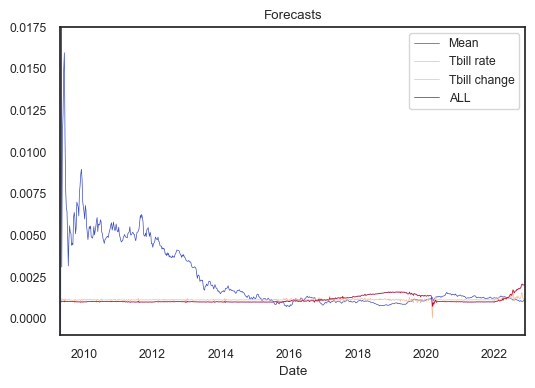

In [40]:
forecasts.plot(figsize=(6, 4), cmap="coolwarm", lw = 0.5, title='Forecasts')
plt.ylim(-0.001, 0.0175)
plt.show()

### 2 Trading Weights

In [41]:
wts = 0.2 + 80 * forecasts
fund_returns = wts * gld.values

In [42]:
print(f"First 5 values: \n{fund_returns.ALL.head()}")

First 5 values: 
Date
2009-04-26    0.0148
2009-05-03   -0.0086
2009-05-10    0.0099
2009-05-17    0.0049
2009-05-24    0.0080
Name: ALL, dtype: float64


In [43]:
print(f"Last 5 values: \n{fund_returns.ALL.tail()}")

Last 5 values: 
Date
2022-11-06    0.0078
2022-11-13    0.0187
2022-11-20   -0.0039
2022-11-27    0.0010
2022-12-04   -0.0011
Name: ALL, dtype: float64


### 3

In [44]:
performance_summary(gld, adj_factor=12).T

,GLD
Mean,0.0136
Volatility,0.0732
Sharpe Ratio,0.1859


In [45]:
performance_summary(fund_returns, adj_factor=12).loc['ALL']

Mean           0.0040
Volatility     0.0209
Sharpe Ratio   0.1911
Name: ALL, dtype: float64

`GLD` offers higher returns due to the higher mean, but it also involves greater risk, represented by a higher volatility. Still, the `GLD`'s Sharpe ratio are comparable to the ALL (0.1859 vs 0.1911). The slightly higher Sharpe ratio indicates marginally better risk-adjusted performance.

Gold seems better to me as the slightly higher returns are prioritized over risk. BUT ULTIMATELY, the better strategy hinges on the investor's risk tolerance. ALL would seem more suitable for investors seeking lower volatility and marginally better risk-adjusted returns.

### 4


The model with the Tbill rate as the signal has an R-squared value of 0.000105, which is higher than the model with the Tbill change as the signal, which has an R-squared value of 0.000012. This suggests that Tbill rate has a slightly stronger relationship with the GLD return, and would thus be more likely to forecast future movements in GLD more accurately.

Also, interest rates (`Tbill rate`) have compounding effects over long periods. Higher interest rates increase the opportunity cost of holding gold which does not offer a yield, pushing the price down, and vice versa. This relationship is more stable and reliable over long periods, as compared to changes in Tbill yields which can be more erratic.

Therefore, the `Tbill rate` is more likely to compound the effect over long horizons, similar to the dividend-price ratios used in forecasting SPY.
